In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

/home/metod/miniconda3/envs/laplace/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def show_anns(anns, seed=0):
    np.random.seed(seed)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [24]:
image = cv2.imread('images/dog.jpg')
print(image.shape, image.dtype, image.min(), image.max())
# image = cv2.imread('images/munich_000397_000019_leftImg8bit.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape, image.dtype, image.min(), image.max())

(534, 800, 3) uint8 0 255
(534, 800, 3) uint8 0 255


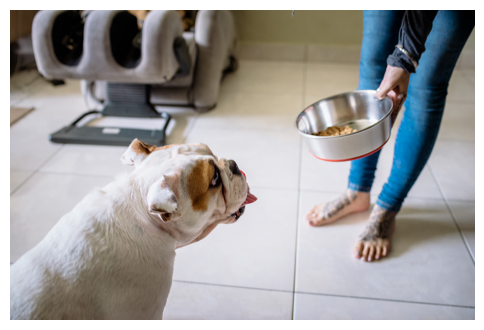

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"
sam_checkpoint = "../models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam, stability_score_thresh=0., pred_iou_thresh=0.)
mask_generator = SamAutomaticMaskGenerator(sam)
# mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=16)

To generate masks, just run `generate` on an image.

In [10]:
masks = mask_generator.generate(image)

Time for image encoder:  0.7083280086517334
Time for mask decoding:  3.646707057952881


In [11]:
masks_ee = mask_generator.generate_ee(image)

Time for image encoder:  0.22388958930969238
torch.Size([12, 1, 256, 64, 64])


In [20]:
for l in range(11):
    print(l, mask_generator.predictor.h_cos_sim[l].mean(), mask_generator.predictor.h_cos_sim[l].std())

0 tensor(0.7973, device='cuda:0') tensor(0.0578, device='cuda:0')
1 tensor(0.9511, device='cuda:0') tensor(0.0090, device='cuda:0')
2 tensor(0.9662, device='cuda:0') tensor(0.0098, device='cuda:0')
3 tensor(0.9715, device='cuda:0') tensor(0.0096, device='cuda:0')
4 tensor(0.9686, device='cuda:0') tensor(0.0113, device='cuda:0')
5 tensor(0.9870, device='cuda:0') tensor(0.0083, device='cuda:0')
6 tensor(0.9910, device='cuda:0') tensor(0.0065, device='cuda:0')
7 tensor(0.9880, device='cuda:0') tensor(0.0092, device='cuda:0')
8 tensor(0.9949, device='cuda:0') tensor(0.0039, device='cuda:0')
9 tensor(0.9970, device='cuda:0') tensor(0.0023, device='cuda:0')
10 tensor(0.9969, device='cuda:0') tensor(0.0021, device='cuda:0')


In [13]:
for l in range(len(masks_ee)):
    print(l, 
          len(masks_ee[l]), 
          round(np.mean([masks_ee[l][i]['stability_score'] for i in range(len(masks_ee[l]))]), 3), 
          round(np.mean([masks_ee[l][i]['predicted_iou'] for i in range(len(masks_ee[l]))]), 3))

0 0 nan nan
1 0 nan nan
2 0 nan nan
3 3 0.954 0.894
4 3 0.961 0.902
5 7 0.969 0.911
6 12 0.963 0.918
7 17 0.967 0.933
8 28 0.963 0.936
9 35 0.965 0.933
10 39 0.966 0.932
11 44 0.966 0.938


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [12]:
print(len(masks))
print(masks[0].keys())

44
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

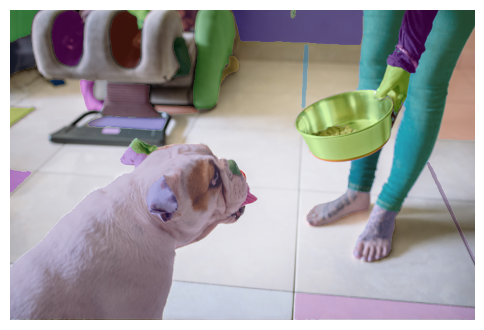

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

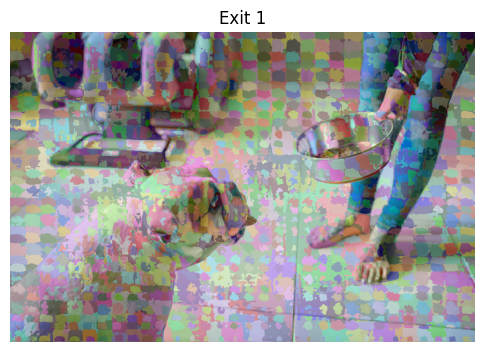

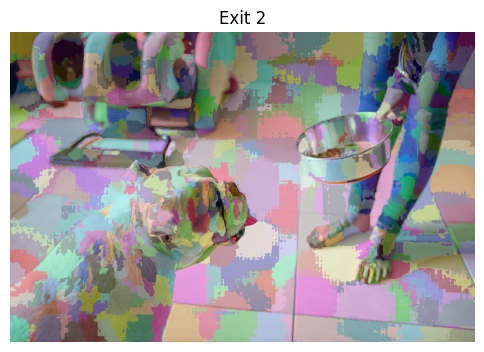

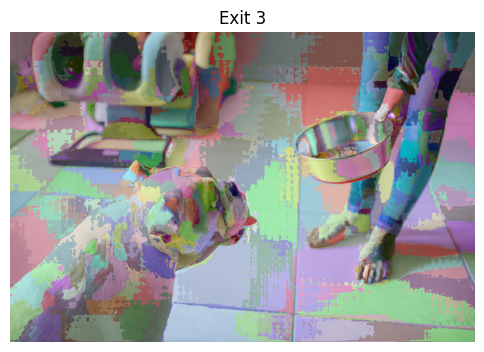

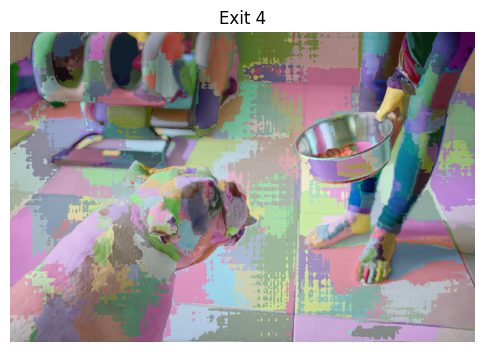

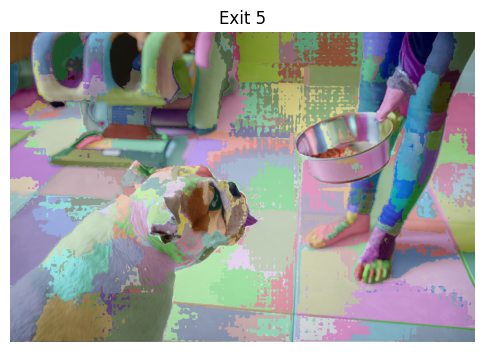

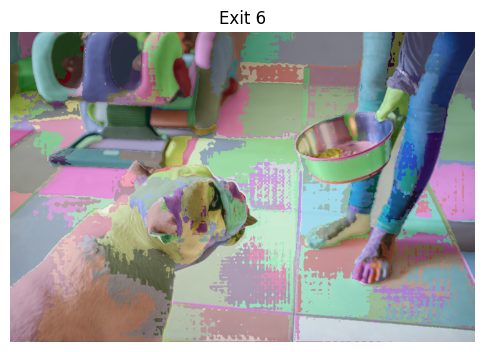

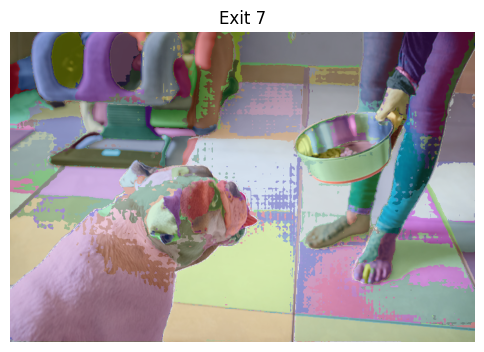

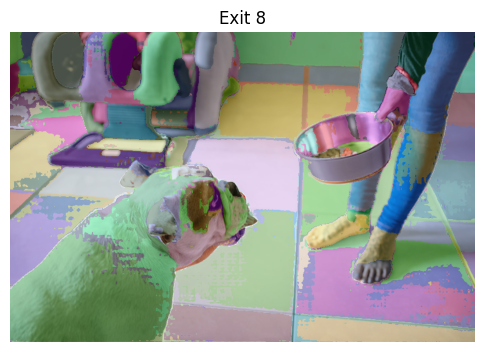

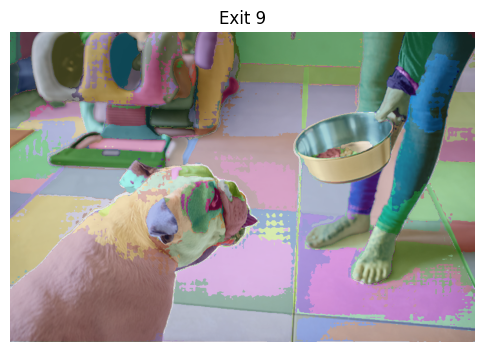

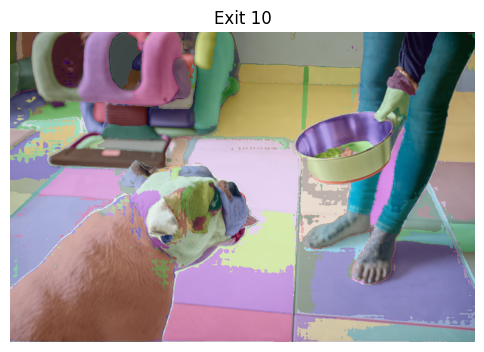

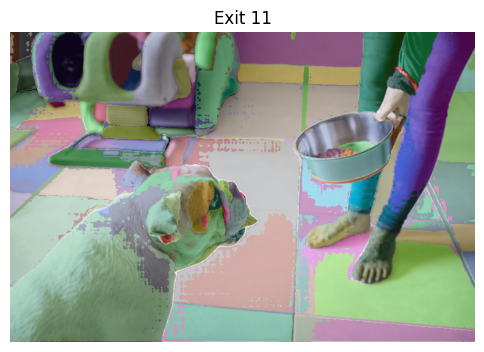

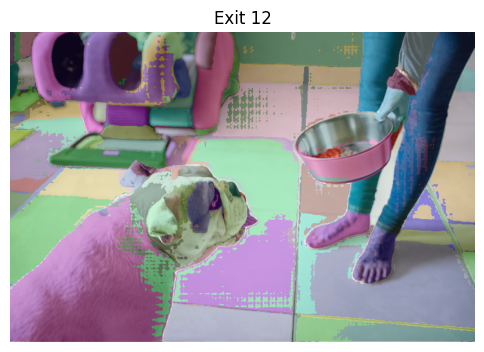

In [15]:
for l in range(len(masks_ee)):
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    show_anns(masks_ee[l])
    plt.title(f"Exit {l + 1}")
    plt.axis('off')
    plt.show() 

Time for image encoder:  0.23725128173828125
Time for mask decoding:  0.05103754997253418


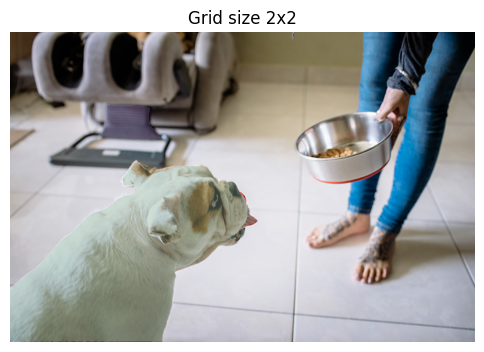

Time for image encoder:  0.22613978385925293
Time for mask decoding:  0.08518528938293457


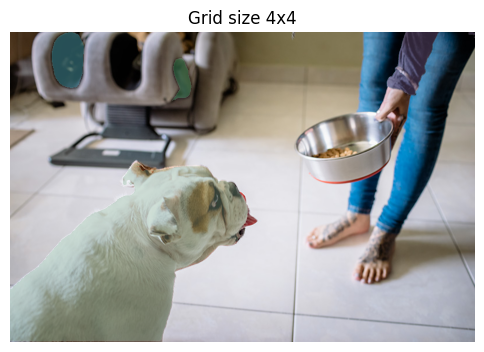

Time for image encoder:  0.21984314918518066
Time for mask decoding:  0.24876189231872559


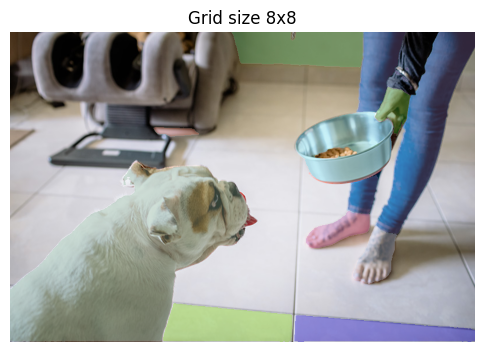

Time for image encoder:  0.2200942039489746
Time for mask decoding:  1.0927906036376953


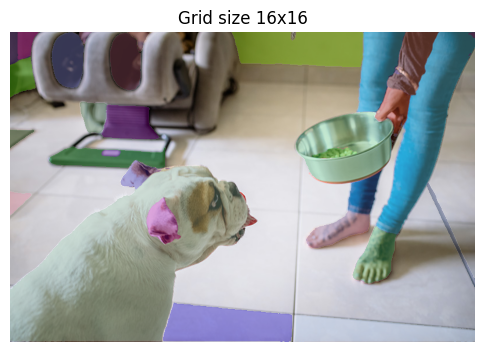

Time for image encoder:  0.22257518768310547
Time for mask decoding:  1.7096014022827148


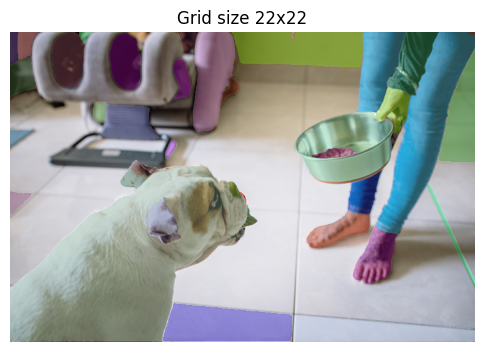

Time for image encoder:  0.22053980827331543
Time for mask decoding:  3.503046989440918


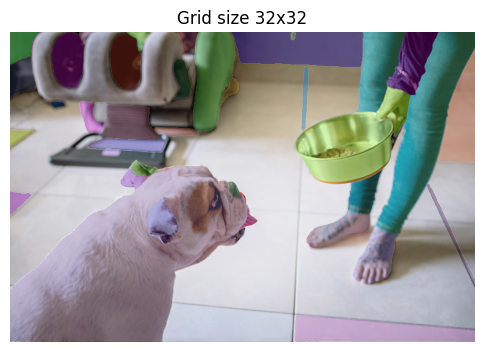

In [12]:
for grid_size in [2, 4, 8, 16, 22, 32]:
    mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=grid_size, points_per_batch=256)
    masks = mask_generator.generate(image)
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    show_anns(masks)
    plt.title(f"Grid size {grid_size}x{grid_size}")
    plt.axis('off')
    plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [16]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [17]:
masks2 = mask_generator_2.generate(image)

Time for image encoder:  0.23328042030334473
Time for mask decoding:  3.754666328430176
Time for image encoder:  0.22098970413208008
Time for mask decoding:  0.8713352680206299
Time for image encoder:  0.22134709358215332
Time for mask decoding:  0.9091060161590576
Time for image encoder:  0.2207505702972412
Time for mask decoding:  0.8875091075897217
Time for image encoder:  0.221998929977417
Time for mask decoding:  0.866539716720581


In [18]:
len(masks2)

63

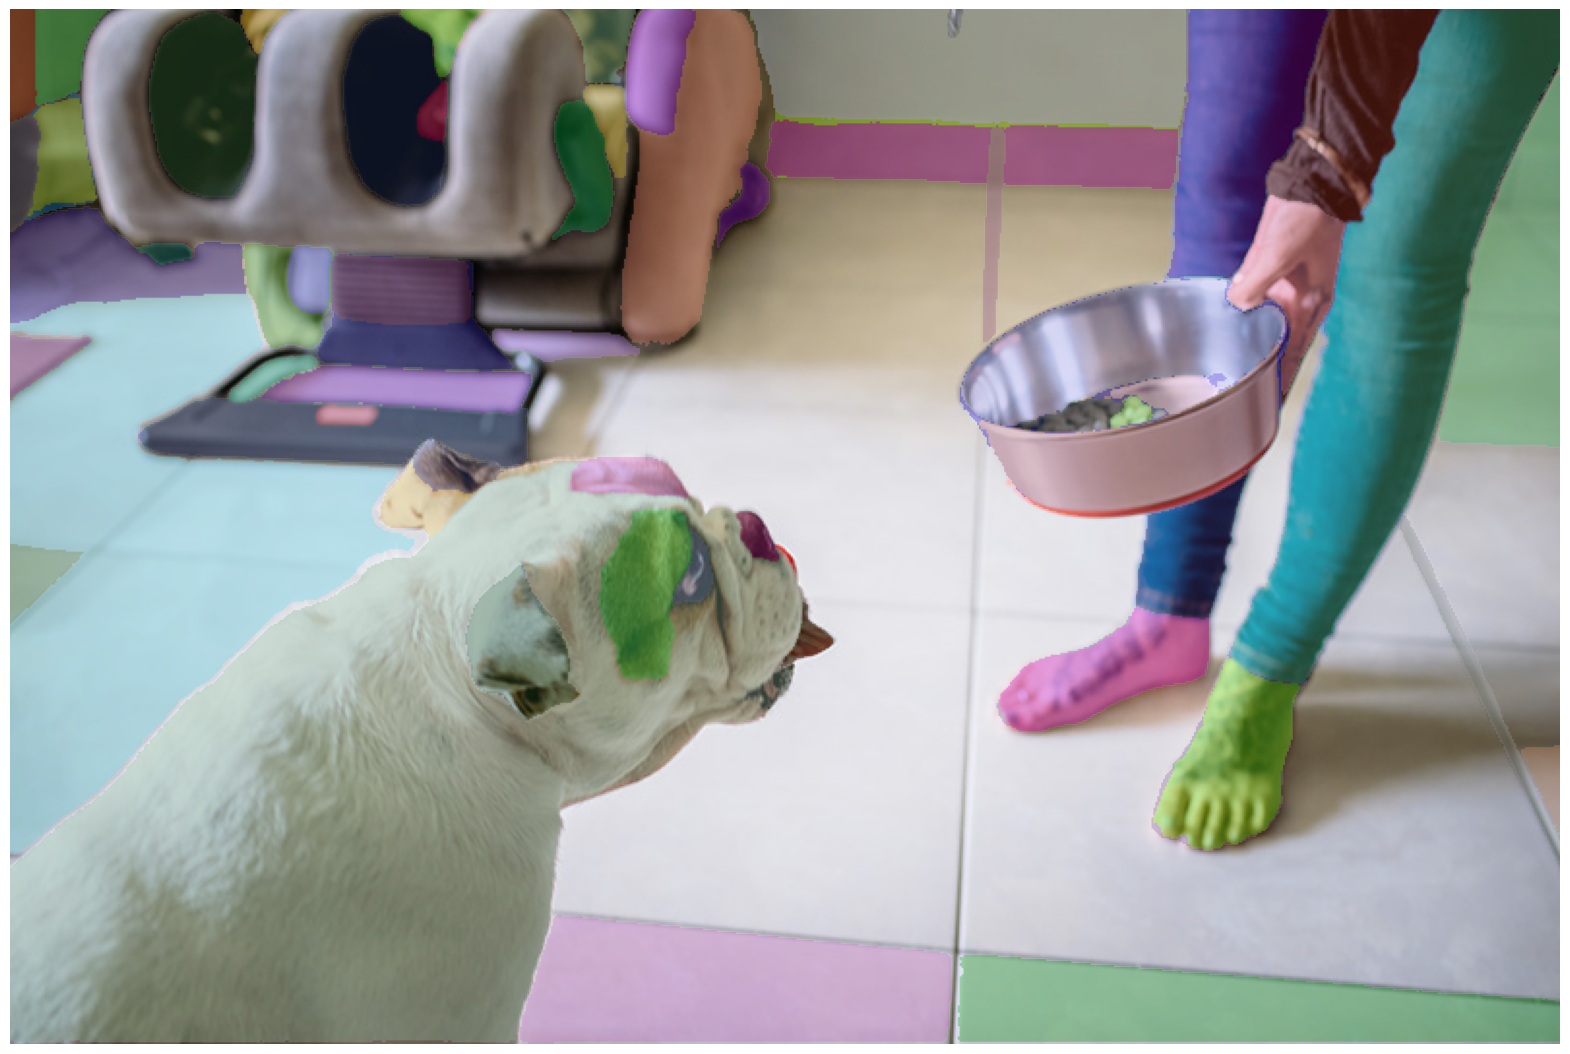

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 